In [4]:
import numpy as np
import matplotlib.pyplot as plt



import sys
import os
BASE_PATH = './../dynaphos-core/'
sys.path.append(BASE_PATH)

from dynaphos import utils
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy
from dynaphos import cortex_models

import torch

# from matplotlib_scalebar.scalebar import ScaleBar

In [5]:
# Load colorstyles 
plt.style.use('../_figurestyle/small.mplstyle')
COLORSTYLE = utils.load_params('../_figurestyle/colors.yaml')

LINE_COLOR = COLORSTYLE['red'][1]
BOUNDS_COLOR = COLORSTYLE['turquoise'][2]

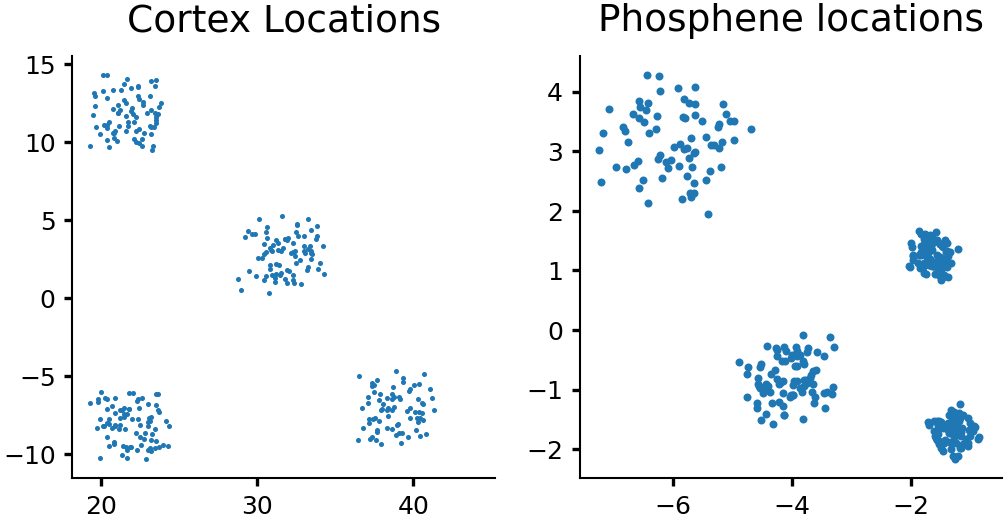

In [6]:
PLOT_TRUE_CORTEX_LOCATIONS = True # set true for plotting the distorted cortex locations corresponding to the phosphenes. 


# read parameters from yaml file
params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))

# initialise phopshene locations, either using a cortex model or semi-probabilistically
x,y = utils.load_coordinates_from_yaml(os.path.join(BASE_PATH, 'config', 'grid_coords_squares_utah.yaml'))
coordinates_cortex = Map(x,y)
coordinates_visual_field = get_visual_field_coordinates_from_cortex(params['cortex_model'], coordinates_cortex)

if PLOT_TRUE_CORTEX_LOCATIONS:
    # plot electrode locations (convert back from phosphene locataions to capture the added dropout and noise)
    visual_field_to_cortex = cortex_models.get_mapping_from_visual_field_to_cortex(params['cortex_model'])
    z = coordinates_visual_field.flip(hor=True, vert=True).complex
    coordinates_cortex = Map(z=visual_field_to_cortex(z))

    
# Plot cortex locations
fig, axs = plt.subplots(1,2, figsize=(4,2))
axs[0].scatter(*coordinates_cortex.cartesian, marker= '.', s=2)
axs[0].axis('square')
axs[0].set_title('Cortex Locations')


# plot phosphene locations
r, phi = coordinates_visual_field.polar
axs[1].scatter(r*np.cos(phi),r*np.sin(phi), s=2)
axs[1].axis('square')
axs[1].set_title('Phosphene locations')
plt.show()

# initialise simulator
simulator = PhospheneSimulator(params, coordinates_visual_field)
N_PHOSPHENES = simulator.num_phosphenes

data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

RESOLUTION = params['run']['resolution']

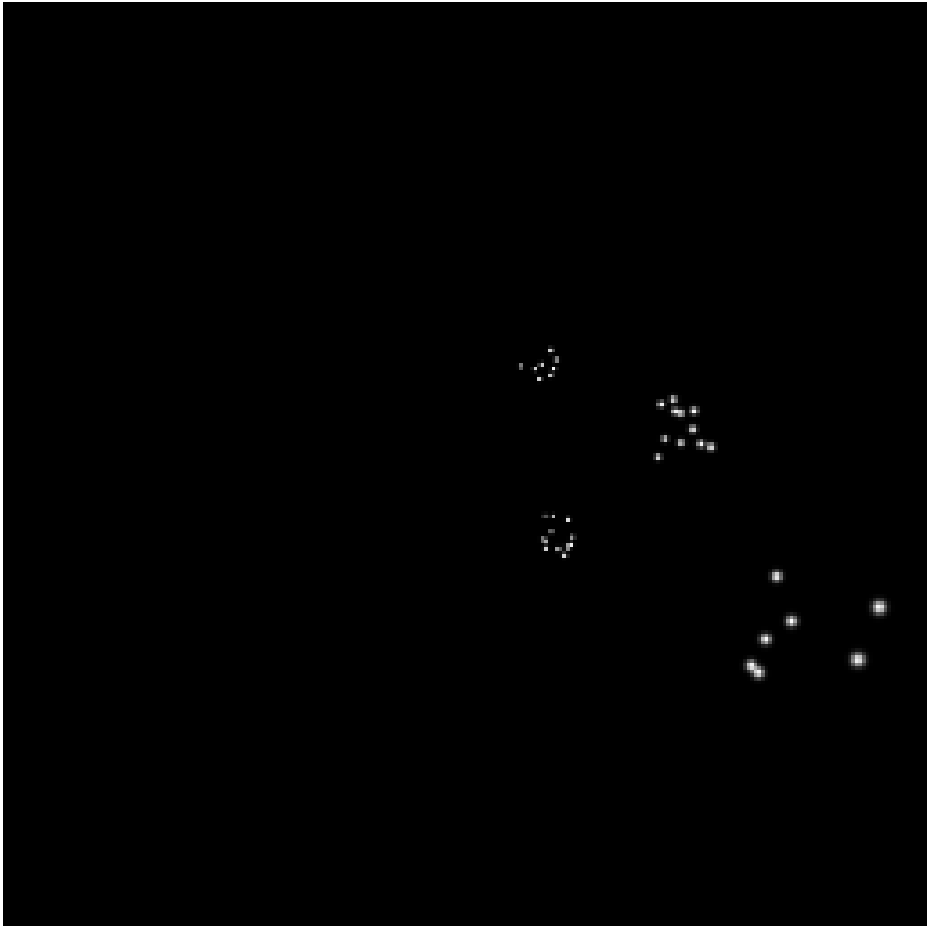

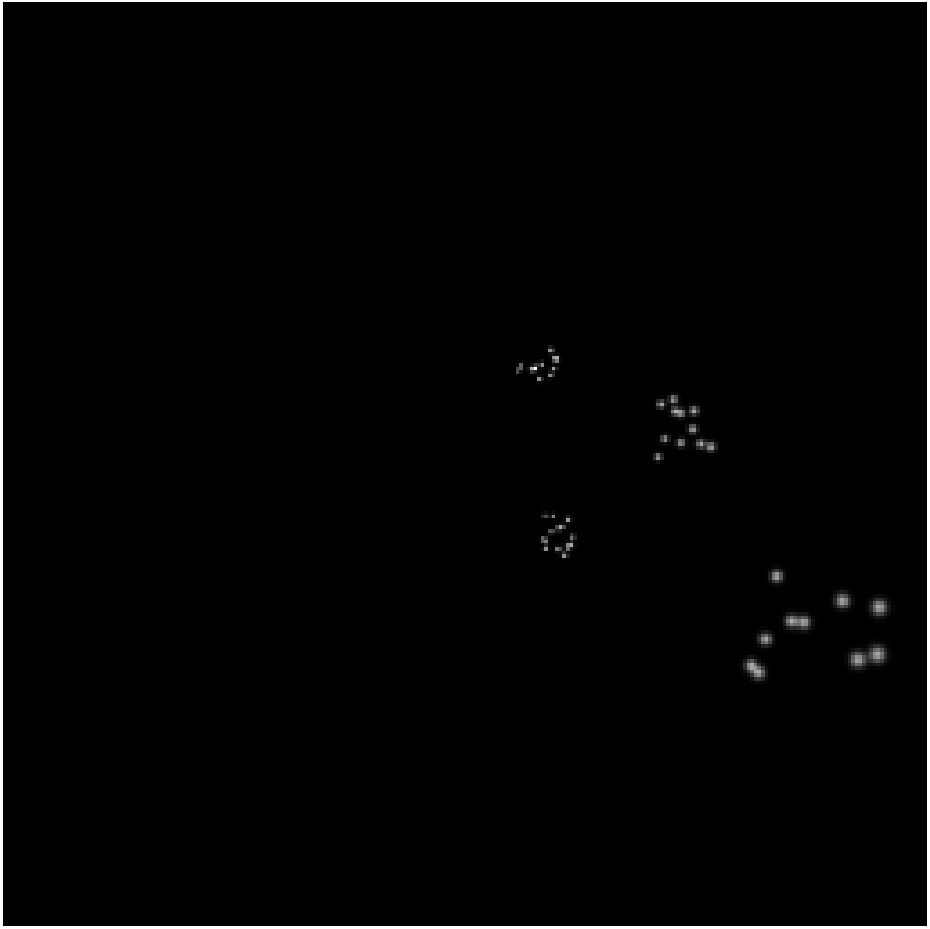

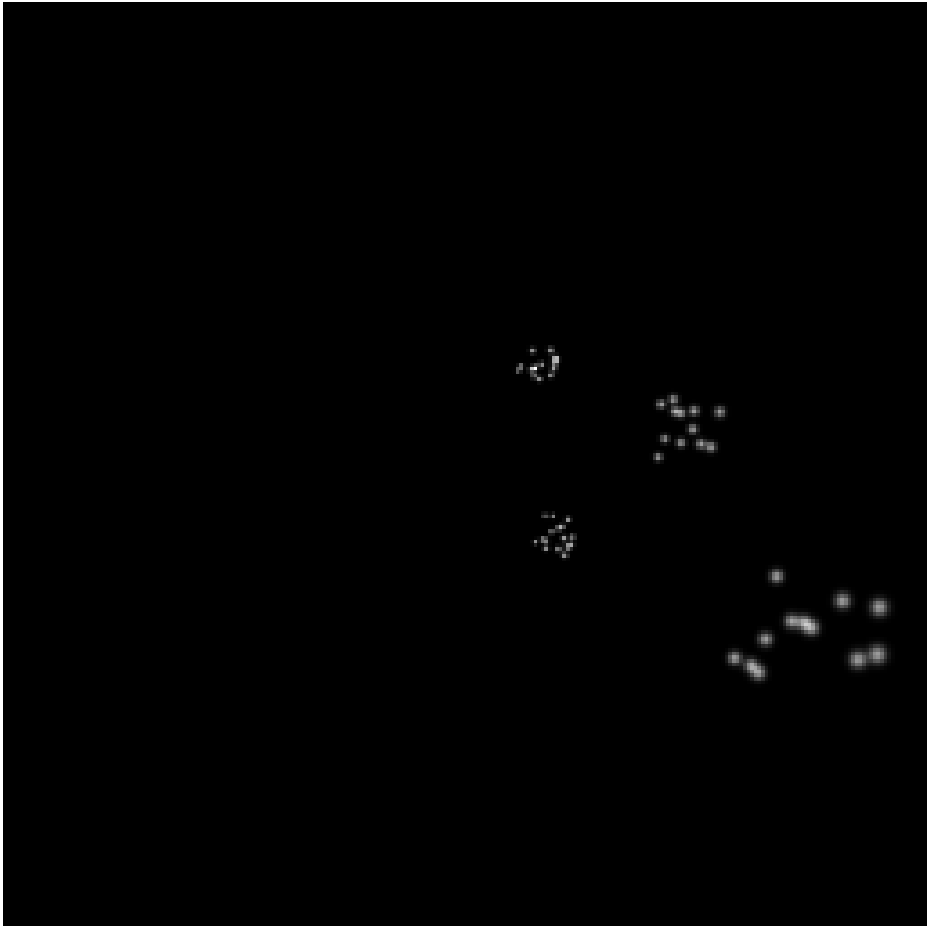

In [7]:
# initialise simulator
simulator = PhospheneSimulator(params, coordinates_visual_field)
N_PHOSPHENES = simulator.num_phosphenes

data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

RESOLUTION = params['run']['resolution']

# plot phosphenes for different input strengths
stims = np.array([60.,80.,100.])*1e-6

imgs = []
for i,stim in enumerate(stims):

    simulator.reset()
    stim_pattern = stim*torch.ones(N_PHOSPHENES,device=device)
    img = to_numpy(simulator(stim_pattern)).clip(max=1)
    imgs.append(img)

    plt.imshow(img,cmap='gray',origin='lower')
    plt.axis('off')
    plt.show()

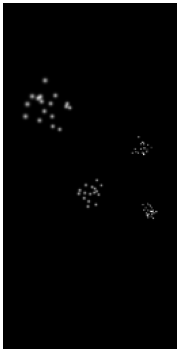

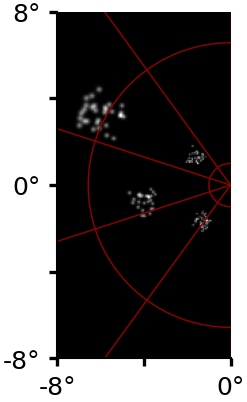

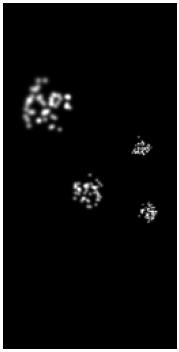

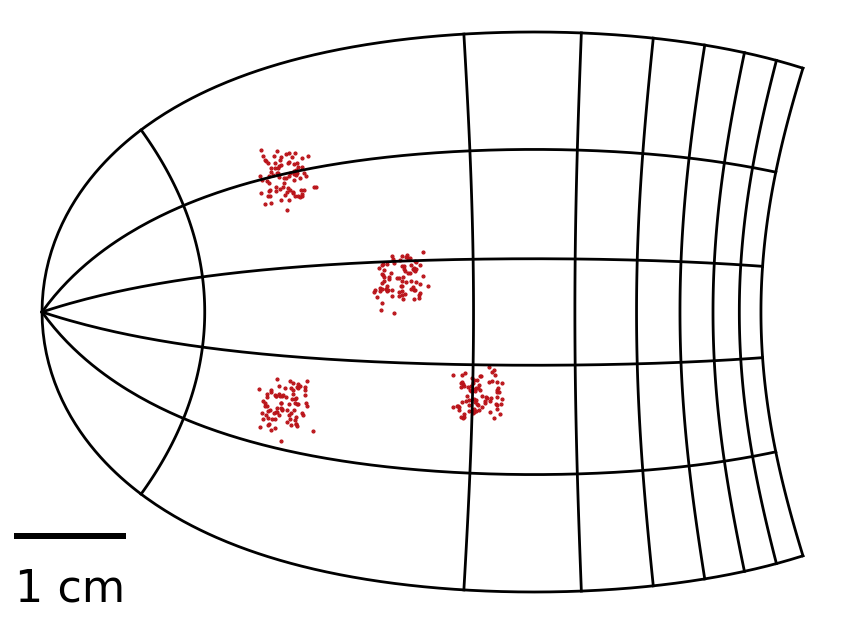

In [82]:
# Mapping from visual field to cortex (for creating the cortex model grid)
visual_field_to_cortex = cortex_models.get_mapping_from_visual_field_to_cortex(params['cortex_model'])

# Initialize figures
# fig, axs = plt.subplots(1,3, figsize=(3,1.5), dpi=300)

_, ax_0 = plt.subplots(1,1, figsize=(1,1.5), dpi=300)
_, ax_1 = plt.subplots(1,1, figsize=(1,1.5), dpi=300) 
_, ax_2 = plt.subplots(1,1, figsize=(1,1.5), dpi=300)

_, ax_3 = plt.subplots(1,1, figsize=(2.7,2), dpi=400)

axs = [ax_0, ax_1, ax_2, ax_3] 

# Plot the radial grid lines    
for angle in np.linspace(.5*np.pi,1.5*np.pi,6) :
    r = []
    phi = []
    for radius in np.linspace(0,40,1000):
        r.append(radius)
        phi.append(angle)
    
    visual_field = Map(r = np.array(r), phi = np.array(phi))
    ax_1.plot(*visual_field.cartesian,linewidth=.35, color=COLORSTYLE['red'][0])
    
    w = visual_field.flip(hor=True, vert=True).complex
    cortex = Map(z=visual_field_to_cortex(w))
    ax_3.plot(*cortex.cartesian, 'k',linewidth=.5)
    
    
# Plot the concentric grid lines
for radius in np.linspace(1,40,8):
    r = []
    phi = []
    for angle in np.linspace(.5*np.pi,1.5*np.pi,100):
        r.append(radius)
        phi.append(angle)
    
    visual_field = Map(r = np.array(r), phi = np.array(phi))
    ax_1.plot(*visual_field.cartesian,linewidth=.35, color=COLORSTYLE['red'][0])
    
    w = visual_field.flip(hor=True, vert=True).complex
    cortex = Map(z=visual_field_to_cortex(w))
    ax_3.plot(*cortex.cartesian, 'k',linewidth=.5)


# Plot phosphenes
for i, img in enumerate(imgs):
    axs[i].imshow(img,cmap='gray',origin='lower', extent=[-8,8, -8,8] )
    axs[i].set(xlim=[-8,0], ylim=[-8,8])
axs[1].set_xticks([-8, -4, 0])
axs[1].set_xticklabels(['-8°','', '0°'])
axs[1].set_yticks([-8, -4, 0, 4, 8])
axs[1].set_yticklabels(['-8°', '','0°', '', '8°'])
axs[0].axis('off')
axs[2].axis('off')
   

# Plot electrodes
ax_3.scatter(*coordinates_cortex.cartesian, marker= '.', color=COLORSTYLE['red'][1], s=0.25)
ax_3.axis('off')
sb = ScaleBar(1, 'mm', location='lower left')
ax_3.add_artist(sb)
# ax_3.set(xlim=[0,60], ylim=[-30,30])

# # Uncomment to show scalebar instead of axes
# axs[1].axis('off')
# sb = ScaleBar(1, 'deg',dimension='angle', location='lower right', color='w', box_alpha=0, font_properties={'size':7})
# axs[1].add_artist(sb) 


## From NestorSimulator

In [40]:
import pandas as pd
import seaborn as sns
filename = "../../eLife_UtahPictures/StateOfElectrodeContactPoints_utahRFs.txt"
elecs = pd.read_fwf(filename, skiprows=6, index=False)

In [46]:
coordinates_visual_field

In [32]:
elecs.set_index('#')

,Coords,in [model,space],[world,space].1,Unnamed: 6,[voxel,space].2,Unnamed: 9,pRF [x,y s],Unnamed: 12
#,,,,,,,,,,,,
1,-0.24,1.4,-1.38,85.29,-8.37,8.03,281.35,171.46,138.97,2.12,0.04,-1.0
2,-0.24,1.0,-1.38,85.43,-8.37,7.66,281.54,171.46,138.44,2.08,0.18,-1.0
3,-0.24,0.6,-1.38,85.57,-8.37,7.28,281.74,171.46,137.90,2.08,0.18,-1.0
4,-0.24,0.2,-1.38,85.70,-8.37,6.90,281.93,171.46,137.36,2.08,0.18,-1.0
5,-0.24,-0.2,-1.38,85.84,-8.37,6.53,282.13,171.46,136.83,2.08,0.18,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
52,2.24,5.2,9.38,86.33,-19.13,2.45,282.83,186.83,145.29,0.79,0.04,-1.0
53,2.24,4.8,9.38,86.47,-19.13,2.08,283.02,186.83,144.75,0.79,0.04,-1.0
54,2.24,4.4,9.38,86.60,-19.13,1.70,283.22,186.83,144.22,0.82,0.04,-1.0


In [75]:
pRF = elecs.iloc[:,-3:-1]
pRF = pRF.rename({'pRF [x': 'x', 'y s]': 'y'},axis=1)
pRF['y'] = pRF['y']*-1
pRF = pRF[~((pRF['x']==0) & (pRF['y']==0))]

<Axes: xlabel='x', ylabel='y'>

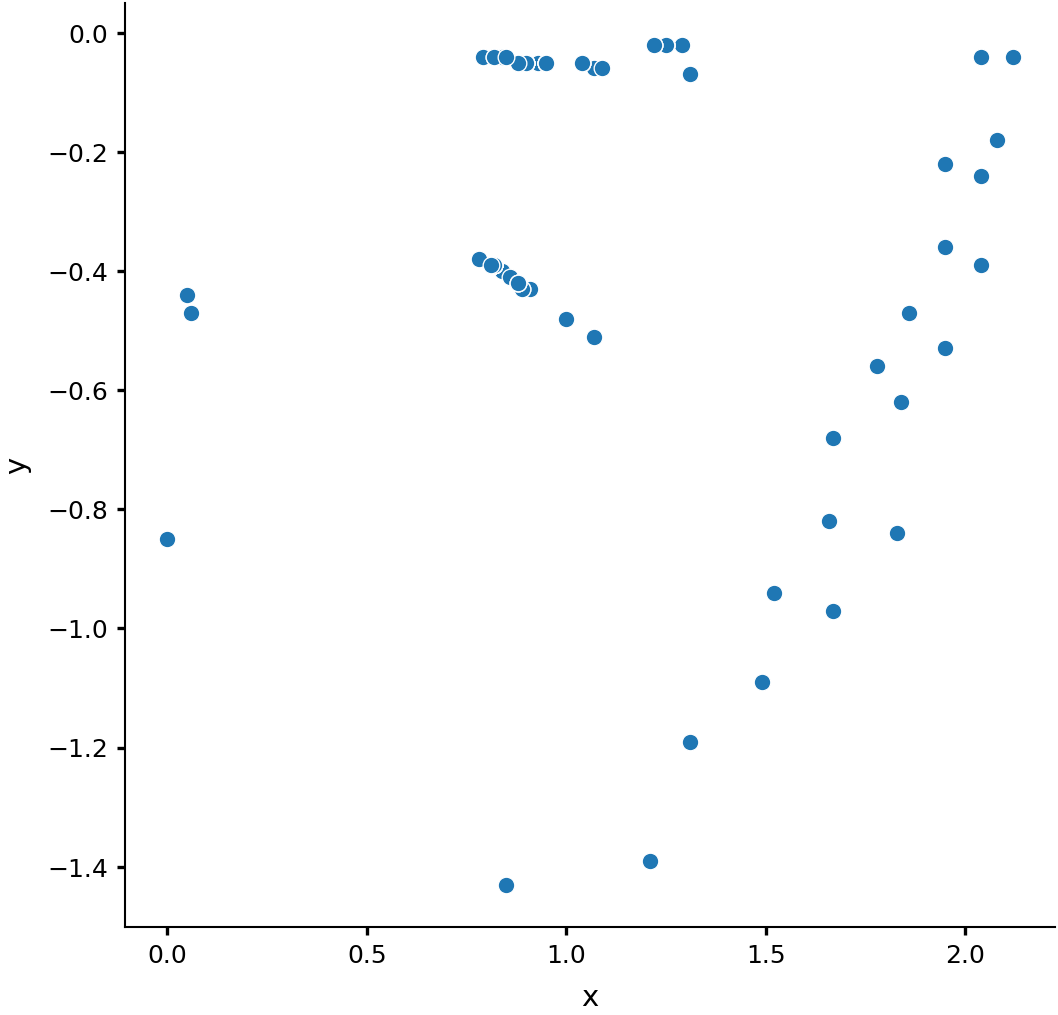

In [76]:
sns.scatterplot(pRF, x='x', y='y')

In [37]:
#to polar
pRF['r'] = np.sqrt(pRF['x']**2+pRF['y']**2)
pRF['phi'] = np.arctan2(pRF['y'],pRF['x'])

,pRF [x,y s]
0,2.12,0.04
1,2.08,0.18
2,2.08,0.18
3,2.08,0.18
4,2.08,0.18
...,...,...
251,0.79,0.04
252,0.79,0.04
253,0.82,0.04
254,0.82,0.04


In [77]:
coordinates_utah_vf = Map(x=np.array(pRF['x']),y=np.array(pRF['y']))

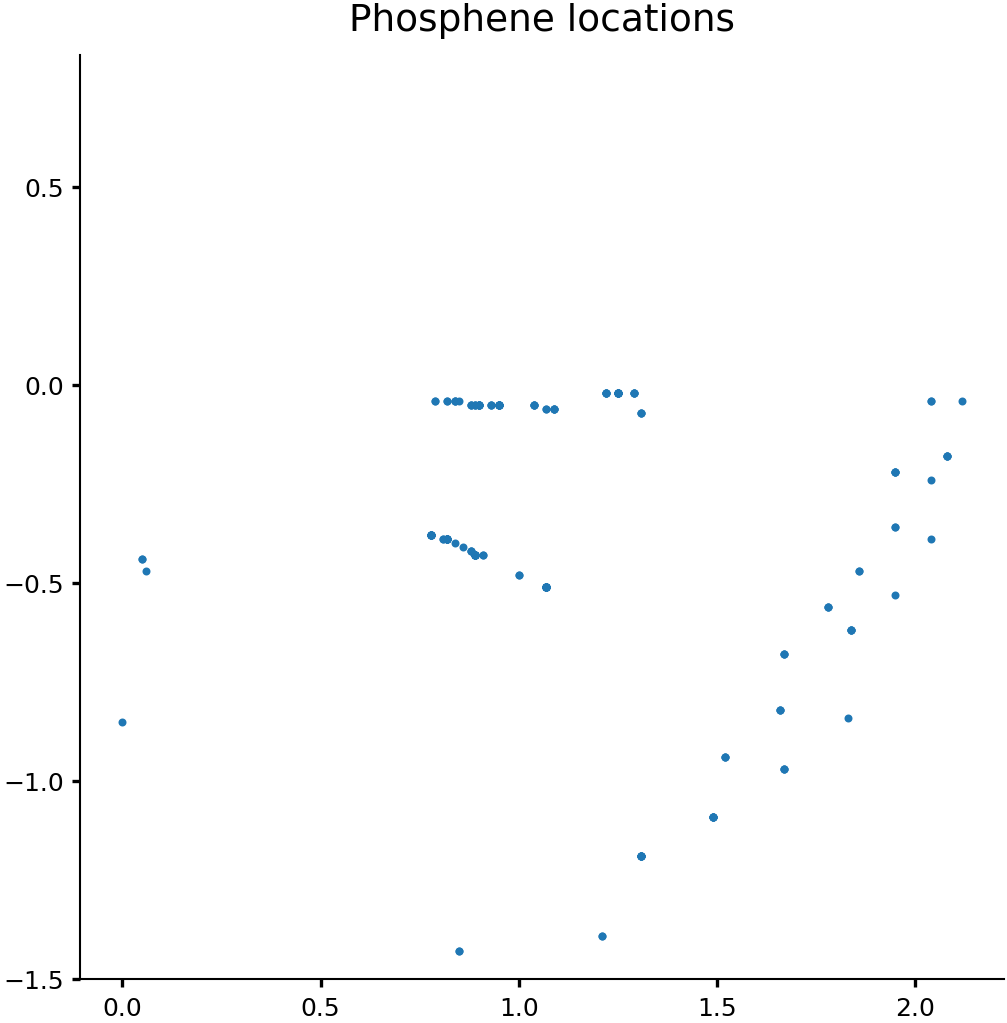

In [78]:
# plot phosphene locations
r, phi = coordinates_utah_vf.polar
plt.scatter(r*np.cos(phi),r*np.sin(phi), s=2)
plt.axis('square')
plt.title('Phosphene locations')
plt.show()

In [150]:
# initialise simulator
params['run']['view_angle'] = 5
params['run']['resolution'] = [1000,1000]
params['thresholding']['use_threshold'] = True

rng = np.random.default_rng(seed=None)
noise = rng.normal(loc=0, scale=0.04, size = (2,len(pRF)))

coordinates_utah_vf = Map(x=np.array(pRF['x'])+noise[0],y=np.array(pRF['y'])+noise[1])
simulator = PhospheneSimulator(params, coordinates_utah_vf)
N_PHOSPHENES = simulator.num_phosphenes

data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

RESOLUTION = params['run']['resolution']

# plot phosphenes for different input strengths
stim = 70e-6#s = np.array([60.,80.,100.])*1e-6

# simulator.reset()


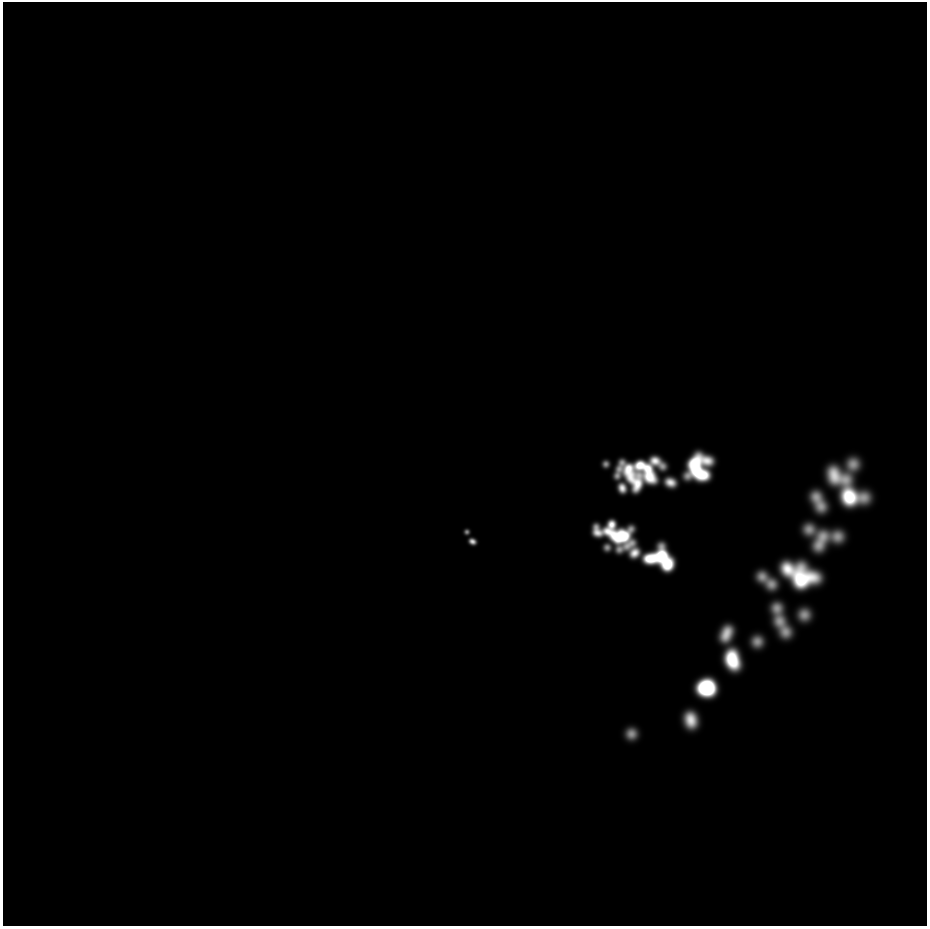

In [157]:
stim_pattern = stim*torch.ones(N_PHOSPHENES,device=device)
img = to_numpy(simulator(stim_pattern)).clip(max=1)

plt.imshow(img,cmap='gray',origin='lower')
plt.axis('off')
plt.show()